In [15]:
# Importing the relevant libraries
import IPython.display
import json
import pandas as pd
import seaborn as sns
import squarify
%matplotlib inline
# import missingno as msno
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import numpy as np
from matplotlib import pyplot as plt

# D3 modules
from IPython.core.display import display, HTML, Javascript
from string import Template
import datetime
from datetime import timedelta

In [83]:
dtypes = {'store_nbr': np.dtype('int64'),
          'item_nbr': np.dtype('int64'),
          'unit_sales': np.dtype('float64'),
          'onpromotion': np.dtype('O')}

items = pd.read_csv("inputs/items.csv")
holiday_events = pd.read_csv("inputs/holidays_events.csv")
stores = pd.read_csv("inputs/stores.csv")
oil = pd.read_csv("inputs/oil.csv")
transactions = pd.read_csv("inputs/transactions.csv")
# Read in the full training data just to get prior information and here is the output:
# Output: "125,497,040 rows | 6 columns"
pd_train = pd.read_csv("inputs/train.csv", nrows=6000000, parse_dates=['date'], dtype=dtypes)

In [84]:

#add missing date
min_oil_date = min(pd_train.date)
max_oil_date = max(pd_train.date)

calendar = []

d1 = min_oil_date
d2 = max_oil_date

delta = d2 - d1         # timedelta

for i in range(delta.days + 1):
    calendar.append(datetime.date.strftime(d1 + timedelta(days=i), '%Y-%m-%d'))

calendar = pd.DataFrame({'date':calendar})

oil = calendar.merge(oil, left_on='date', right_on='date', how='left')

In [85]:
oil.head()

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-05,NaN


In [86]:
#Check how many NA
print(oil.isnull().sum(), '\n')

#Type
print('Type : ', '\n', oil.dtypes)

#Print the 3 first line
oil.head(5)

date           0
dcoilwtico    44
dtype: int64 

Type :  
 date           object
dcoilwtico    float64
dtype: object


,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-05,NaN


In [87]:
#Check index to apply the formula
na_index_oil = oil[oil['dcoilwtico'].isnull() == True].index.values

#Define the index to use to apply the formala
na_index_oil_plus = na_index_oil.copy()
na_index_oil_minus = np.maximum(0, na_index_oil-1)

for i in range(len(na_index_oil)):
    k = 1
    while (na_index_oil[min(i+k,len(na_index_oil)-1)] == na_index_oil[i]+k):
        k += 1
    na_index_oil_plus[i] = min(len(oil)-1, na_index_oil_plus[i] + k )

#Apply the formula
for i in range(len(na_index_oil)):
    if (na_index_oil[i] == 0):
        oil.loc[na_index_oil[i], 'dcoilwtico'] = oil.loc[na_index_oil_plus[i], 'dcoilwtico']
    elif (na_index_oil[i] == len(oil)):
        oil.loc[na_index_oil[i], 'dcoilwtico'] = oil.loc[na_index_oil_minus[i], 'dcoilwtico']
    else:
        oil.loc[na_index_oil[i], 'dcoilwtico'] = (oil.loc[na_index_oil_plus[i], 'dcoilwtico'] + oil.loc[na_index_oil_minus[i], 'dcoilwtico'])/ 2    

In [88]:
oil.head()

,date,dcoilwtico
0,2013-01-01,93.14
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-05,93.16


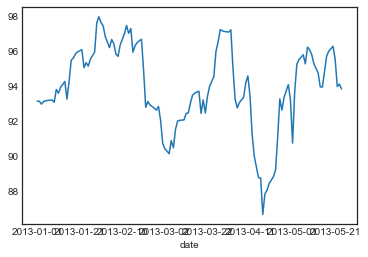

In [89]:
#Plot the oil values
oil_plot = oil['dcoilwtico'].copy()
oil_plot.index = oil['date'].copy()
oil_plot.plot()
plt.show()

In [94]:
holiday_events.head()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [105]:
holiday_events['date'] = pd.to_datetime(holiday_events['date'], format="%Y-%m-%d")
oil['date'] = pd.to_datetime(oil['date'], format="%Y-%m-%d")
holiday_events.dtypes

date           datetime64[ns]
type                   object
locale                 object
locale_name            object
description            object
transferred              bool
dtype: object

In [106]:
#Merge train
# pd_train = pd_train.drop('id', axis = 1)
# pd_train = pd_train.merge(stores, left_on='store_nbr', right_on='store_nbr', how='left')
# pd_train = pd_train.merge(items, left_on='item_nbr', right_on='item_nbr', how='left')
pd_train = pd_train.merge(holiday_events, left_on='date', right_on='date', how='left')
pd_train = pd_train.merge(oil, left_on='date', right_on='date', how='left')
pd_train = pd_train.drop(['description', 'locale_name'], axis = 1)

In [109]:
pd_train[:1000].to_csv("train_merged.csv")

In [3]:
pd_train[0:100].to_csv("train_dataset.csv")

In [4]:
train_2 = pd.read_csv("train_dataset.csv")
train_2.head()

,Unnamed: 0,id,date,store_nbr,item_nbr,unit_sales,onpromotion
0,0,0,2013-01-01,25,103665,7.0,NaN
1,1,1,2013-01-01,25,105574,1.0,NaN
2,2,2,2013-01-01,25,105575,2.0,NaN
3,3,3,2013-01-01,25,108079,1.0,NaN
4,4,4,2013-01-01,25,108701,1.0,NaN


In [4]:
train.describe

<bound method NDFrame.describe of               id       date  store_nbr  item_nbr  unit_sales  onpromotion
0              0 2013-01-01         25    103665         7.0          NaN
1              1 2013-01-01         25    105574         1.0          NaN
2              2 2013-01-01         25    105575         2.0          NaN
3              3 2013-01-01         25    108079         1.0          NaN
4              4 2013-01-01         25    108701         1.0          NaN
...          ...        ...        ...       ...         ...          ...
5999995  5999995 2013-05-24         14    454596         3.0          NaN
5999996  5999996 2013-05-24         14    456870         4.0          NaN
5999997  5999997 2013-05-24         14    456875         3.0          NaN
5999998  5999998 2013-05-24         14    457471         8.0          NaN
5999999  5999999 2013-05-24         14    457556        10.0          NaN

[6000000 rows x 6 columns]>

Taking a peek, we note that the training data only consists of 6 rather measly columns and coupled with the fact that we have approx 125 million rows, there does seem to be a discrepancy in the number of features that we are going to provide our learning model to train on. However that's where the other supplementary files comes in to play as we will most definitely have to join the fields "store_nbr" (store number) and "item_nbr" as well as dates ( bring in daily oil prices). So there is actually quite a lot of potential and avenues for feature enhancement and engineering.

In [5]:
print("Nulls in Oil columns: {0} => {1}".format(oil.columns.values,oil.isnull().any().values))
print("="*70)
print("Nulls in holiday_events columns: {0} => {1}".format(holiday_events.columns.values,holiday_events.isnull().any().values))
print("="*70)
print("Nulls in stores columns: {0} => {1}".format(stores.columns.values,stores.isnull().any().values))
print("="*70)
print("Nulls in transactions columns: {0} => {1}".format(transactions.columns.values,transactions.isnull().any().values))

Nulls in Oil columns: ['date' 'dcoilwtico'] => [False  True]
Nulls in holiday_events columns: ['date' 'type' 'locale' 'locale_name' 'description' 'transferred'] => [False False False False False False]
Nulls in stores columns: ['store_nbr' 'city' 'state' 'type' 'cluster'] => [False False False False False]
Nulls in transactions columns: ['date' 'store_nbr' 'transactions'] => [False False False]


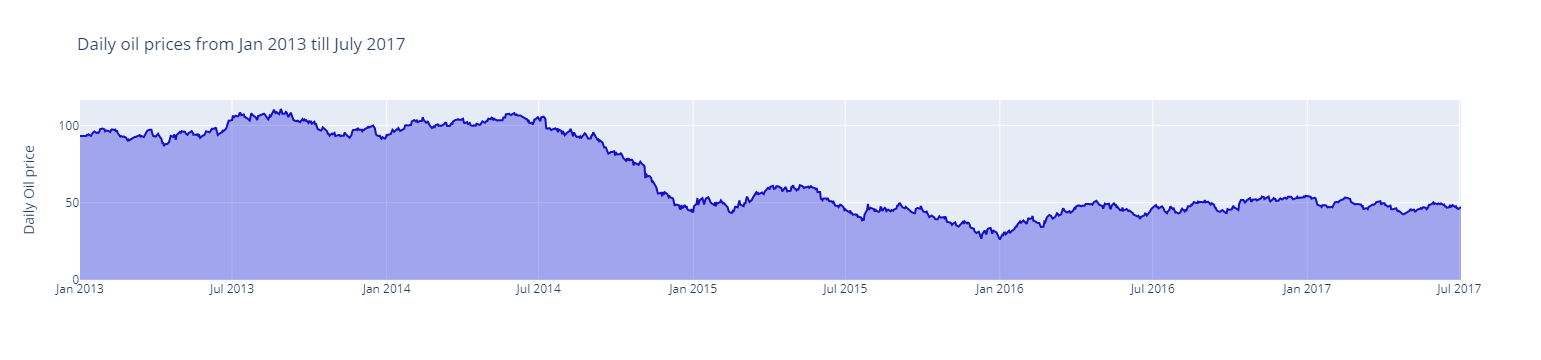

In [6]:
trace = go.Scatter(
    name='Oil prices',
    x=oil['date'],
    y=oil['dcoilwtico'].dropna(),
    mode='lines',
    line=dict(color='rgb(20, 15, 200, 0.8)'),
    #fillcolor='rgba(68, 68, 68, 0.3)',
    fillcolor='rgba(0, 0, 216, 0.3)',
    fill='tonexty' )

data = [trace]

layout = go.Layout(
    yaxis=dict(title='Daily Oil price'),
    title='Daily oil prices from Jan 2013 till July 2017',
    showlegend = False)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='pandas-time-series-error-bars')

Takeaway from the plots

This plot shows that the daily oil price is on a general downward trend from Jan 2013 till July 2017. Where the price of oil started out 2013 by increasing and even busting the 100 dollar mark for a good few months in 2013 and 2014, it reached the middle of 2014 where there was a drastic drop in the price of oil. Via some quick open-source research (i.e Googling), this trend checks out as it seems oil prices were kept fairly stable from 2010 till mid-2014 after which it drastically fell ( due to a confluence of reasons such as weak demand due to poor economic growth and surging alternative sources of crude oil from shale/tar sands).Stores data
With regards to the "stores.csv" file, the data dictionary on the Kaggle competition simply states that it contains metadata on the city, state, the store type and a column termed "cluster". Now this cluster column is a grouping to stores that are similar to each other and as we can see from the latter analysis, there are a total of 17 distinct clusters. With regards to the number of stores, there are a total of 54 stores (based off a unique list of store_nbr) and therefore I presume that all the unit sales and transactions are generated off the data collected from these 54 stores.

Stores data

With regards to the "stores.csv" file, the data dictionary on the Kaggle competition simply states that it contains metadata on the city, state, the store type and a column termed "cluster". Now this cluster column is a grouping to stores that are similar to each other and as we can see from the latter analysis, there are a total of 17 distinct clusters. With regards to the number of stores, there are a total of 54 stores (based off a unique list of store_nbr) and therefore I presume that all the unit sales and transactions are generated off the data collected from these 54 stores.

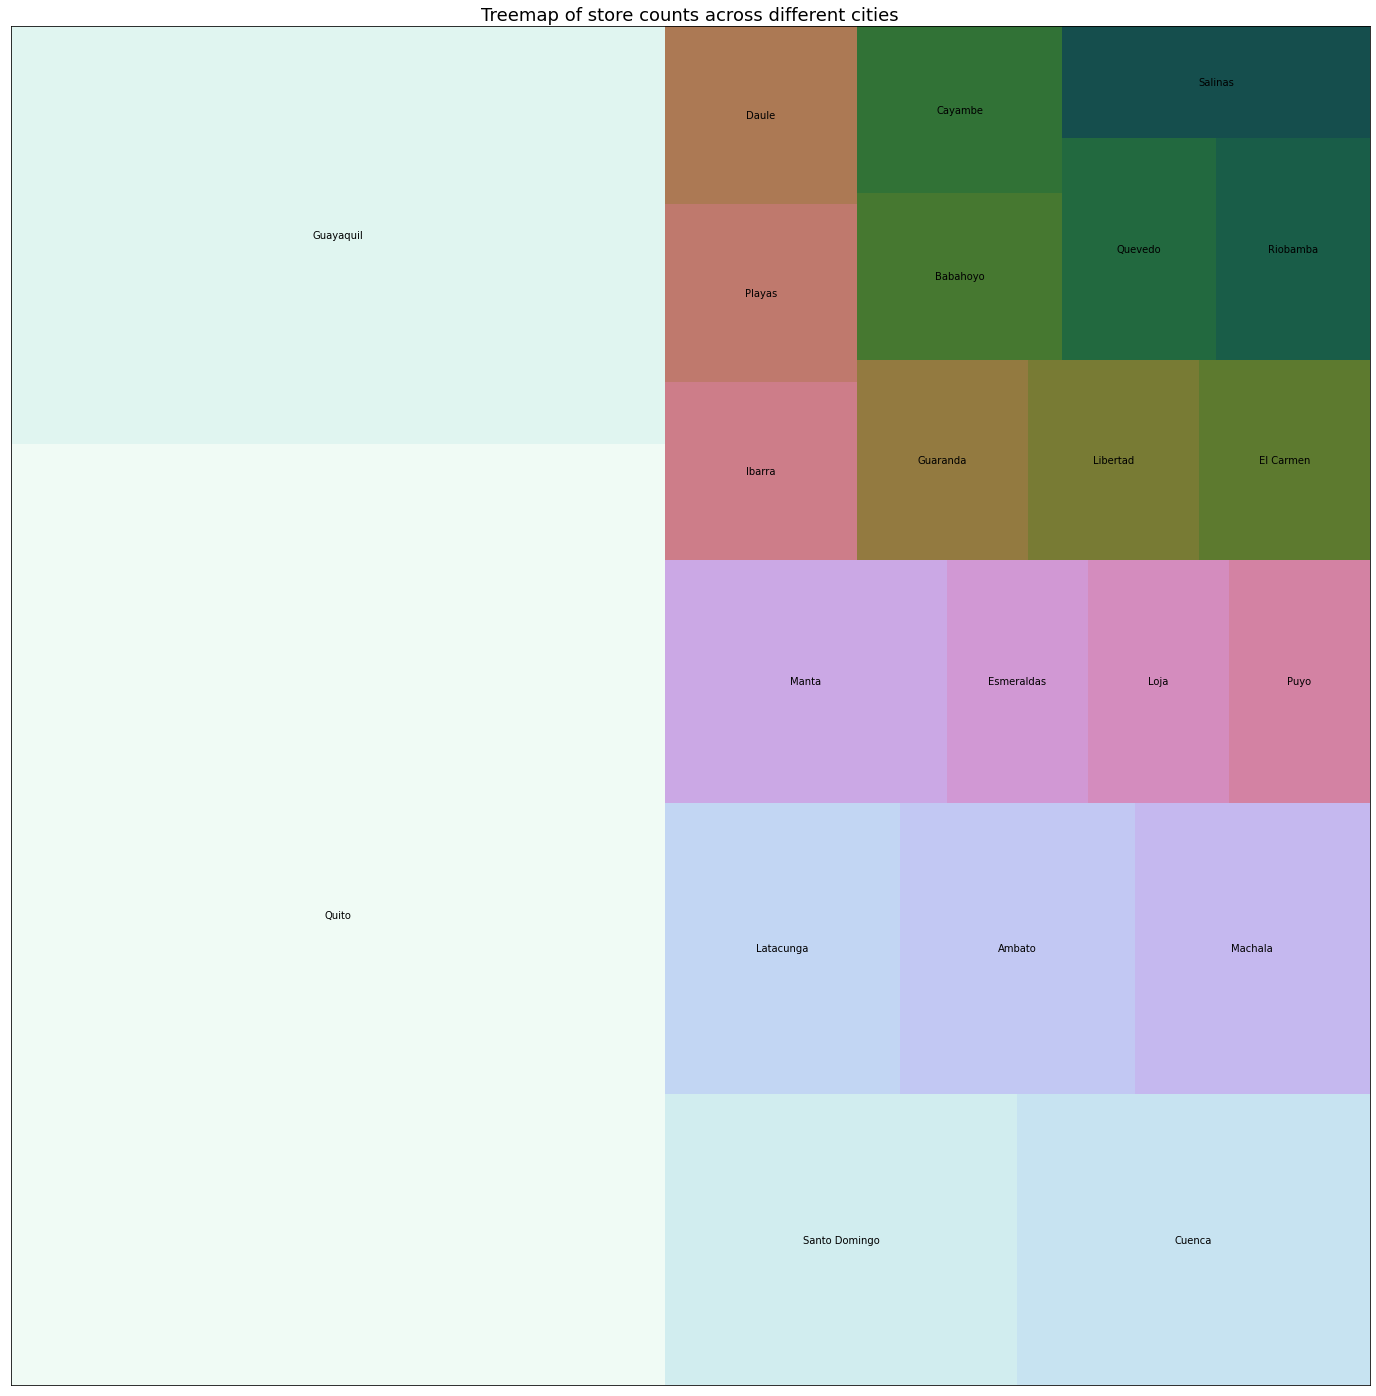

In [7]:
fig = plt.figure(figsize=(25, 21))
marrimeko=stores.city.value_counts().to_frame()
ax = fig.add_subplot(111, aspect="equal")
ax = squarify.plot(sizes=marrimeko['city'].values,label=marrimeko.index,
              color=sns.color_palette('cubehelix_r', 28), alpha=1)
ax.set_xticks([])
ax.set_yticks([])
fig=plt.gcf()
fig.set_size_inches(40,25)
plt.title("Treemap of store counts across different cities", fontsize=18)
plt.show();
fig.savefig('plot.png', dpi=300)

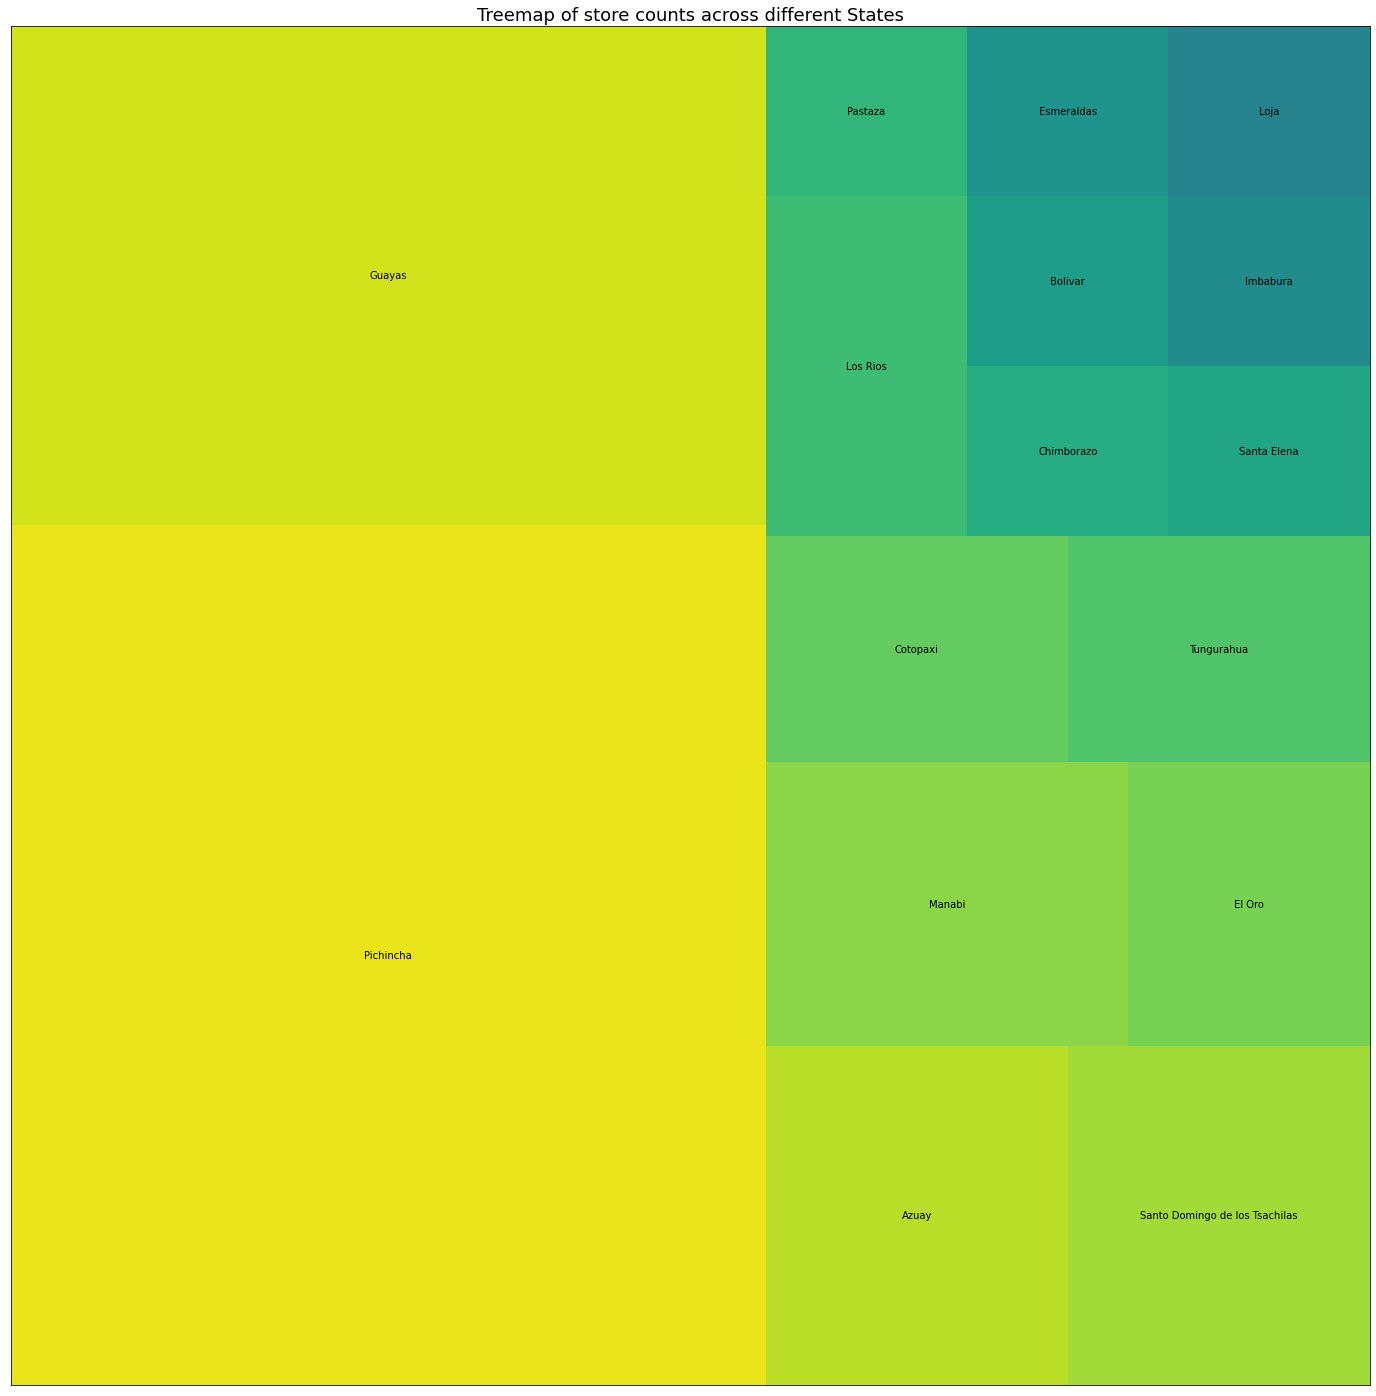

In [8]:
fig = plt.figure(figsize=(25, 21))
marrimeko=stores.state.value_counts().to_frame()
ax = fig.add_subplot(111, aspect="equal")
ax = squarify.plot(sizes=marrimeko['state'].values,label=marrimeko.index,
              color=sns.color_palette('viridis_r', 28), alpha=1)
ax.set_xticks([])
ax.set_yticks([])
fig=plt.gcf()
fig.set_size_inches(40,25)
plt.title("Treemap of store counts across different States", fontsize=18)
plt.show()
fig.savefig('plot2.png', dpi=300)

In [33]:
stores.state.unique()

array(['Pichincha', 'Santo Domingo de los Tsachilas', 'Cotopaxi',
       'Chimborazo', 'Imbabura', 'Bolivar', 'Pastaza', 'Tungurahua',
       'Guayas', 'Santa Elena', 'Los Rios', 'Azuay', 'Loja', 'El Oro',
       'Esmeraldas', 'Manabi'], dtype=object)

Inspecting the allocation of clusters to store numbers

We can now generate will be that of our store numbers ordered against their respective store clusters so that we can observe if there are any apparent trends or relationships in the data. To do so, I will take our stores Python dataframe and group it based on the columns "store_nbr" and "cluster" via the groupby and pivot statement. After which, I will unstack the grouping which means that I will pivot on the level of store_nbr index labels, returning a DataFrame having a new level of columns which are the store clusters whose inner-most level relate to the pivoted store_nbr index labels. This technique is commonly used for producing stacked barplots in Python but since we only have unique store_nbr numbers, therefore we will simply get barplots of store numbers ordered by their relevant clusters.

In [34]:
# Unhide to see the sorted zip order
neworder = [23, 24, 26, 36, 41, 15, 29, 31, 32, 34, 39, 
            53, 4, 37, 40, 43, 8, 10, 19, 20, 33, 38, 13, 
            21, 2, 6, 7, 3, 22, 25, 27, 28, 30, 35, 42, 44, 
            48, 51, 16, 0, 1, 5, 52, 45, 46, 47, 49, 9, 11, 12, 14, 18, 17, 50]

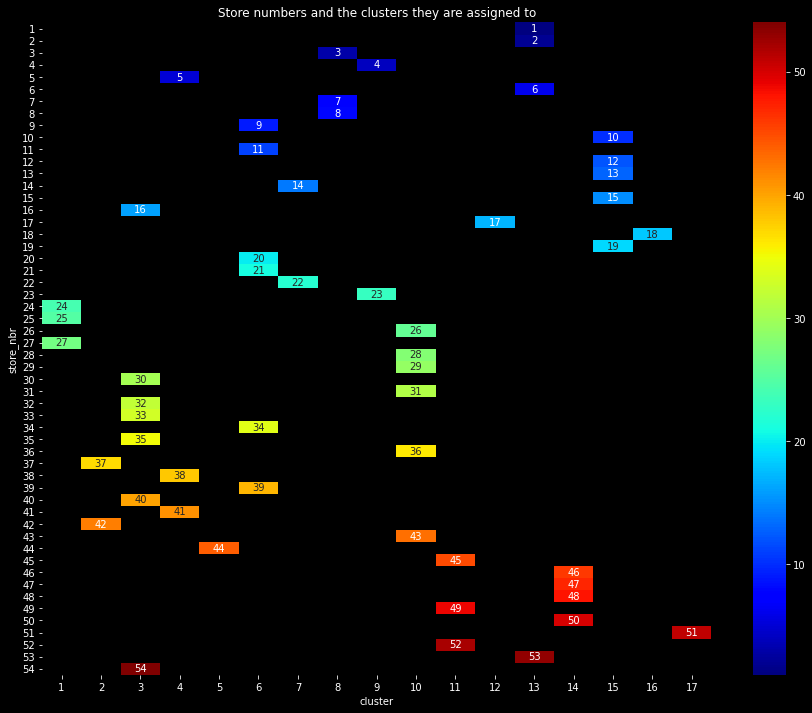

In [9]:
# Finally plot the seaborn heatmap
plt.style.use('dark_background')
plt.figure(figsize=(15,12))
store_pivot = stores.dropna().pivot("store_nbr","cluster", "store_nbr")
ax = sns.heatmap(store_pivot, cmap='jet', annot=True, linewidths=0, linecolor='white')
plt.title('Store numbers and the clusters they are assigned to')
plt.savefig('plot2.png', dpi=300)

Takeaways from thse plot

From visualising the store numbers side-by-side based on the clustering, we can identify certain patterns. For example clusters 3, 6, 10 and 15 are the most common store clusters based off the fact that there are more store_nbrs attributed to them then the others while on the other end of the spectrum, we have clusters 5 and 17 which are only related to the stores 44 and 51 respectively.

Stacked Barplots of Types against clusters

Here it might be informative to look at the distribution of clusters based on the store type to see if we can identify any apparent relationship between types and the way the company has decided to cluster the particular store. Again we apply the groupby operation but this time on type and on cluster. This time when we pivot based off this grouped operation, we are able to get counts of each distinct cluster distributed and stacked on top of other clusters per store type as follows:

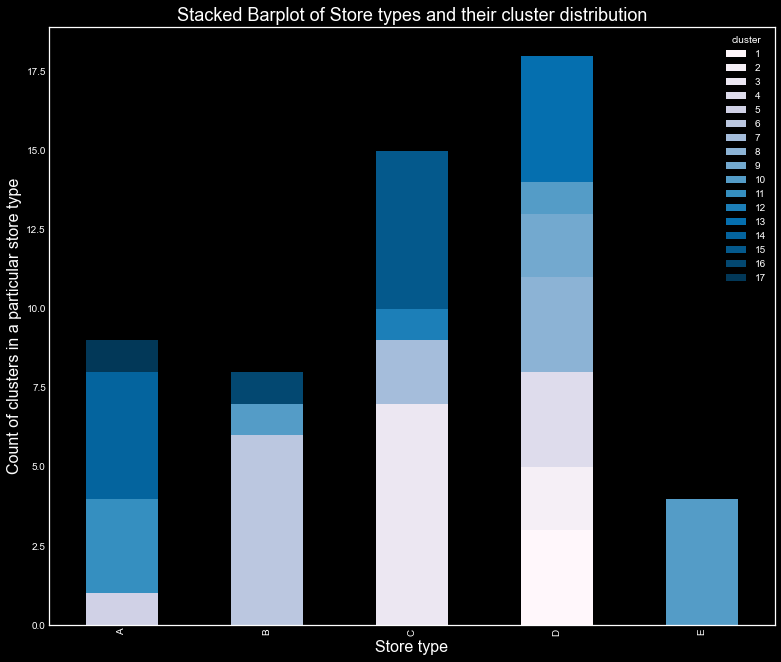

<Figure size 432x288 with 0 Axes>

In [12]:
# plt.style.use('seaborn-white')
plt.style.use('dark_background')
type_cluster = stores.groupby(['type','cluster']).size()
type_cluster.unstack().plot(kind='bar',stacked=True, colormap= 'PuBu', figsize=(13,11),  grid=False)
plt.title('Stacked Barplot of Store types and their cluster distribution', fontsize=18)
plt.ylabel('Count of clusters in a particular store type', fontsize=16)
plt.xlabel('Store type', fontsize=16)
plt.show()
plt.savefig('plot3.png', dpi=300);

Takeaway from the plots

Most of the store types seem to contain a mix of the clusters, especially with regards to store type "D". Only type "E" stores seem to fall within the single cluster of cluster 10. However with regards to our initial plan of trying to suss out relationships between store types and clusters, it seems that there is nothing apparent that stands out. If we think of store types, one would normally think of categories such as convenience store types, huge general store types or bulk buy types.

Stacked barplot of types of stores across the different cities

Another interesting distribution to observe would be the types of stores that Corporacion Favorita has decided to open for each city in Ecuador as well as the absolute number of stores for that city. All these three things can be achieved by turning to our usual groupby operation and pivoting again by unstacking and plotting as follows:# plt.style.use('dark_background')
plt.style.use('seaborn-white')
city_cluster = stores.groupby(['city','type']).store_nbr.size()
city_cluster.unstack().plot(kind='bar',stacked=True, colormap= 'viridis', figsize=(13,11),  grid=False)
plt.title('Stacked Barplot of Store types opened for each city')
plt.ylabel('Count of stores for a particular city')
plt.show()

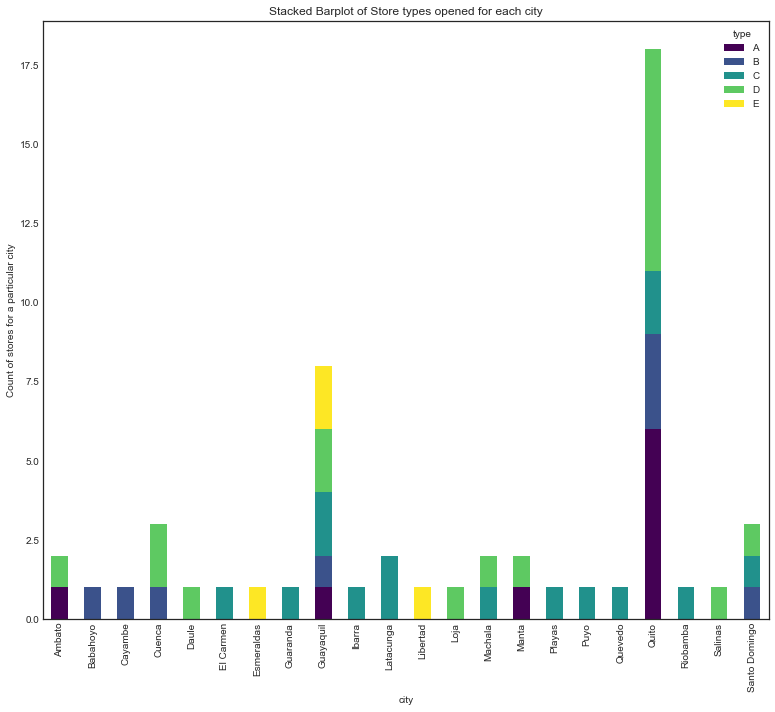

<Figure size 432x288 with 0 Axes>

In [13]:
# plt.style.use('dark_background')
plt.style.use('seaborn-white')
city_cluster = stores.groupby(['city','type']).store_nbr.size()
city_cluster.unstack().plot(kind='bar',stacked=True, colormap= 'viridis', figsize=(13,11),  grid=False)
plt.title('Stacked Barplot of Store types opened for each city')
plt.ylabel('Count of stores for a particular city')
plt.show()
plt.savefig('plot5.png', dpi=300);

Takeaways from the plot:

As observed from the stacked barplots, there are two cities that standout in terms of the variety of store types on offer - Guayaquil and Quito. These should come as no surprise as Quito is the capital city of Ecuador while Guayaquil is the largest and most populous city in Ecuador. Therefore one would think it logical to expect Corporacion Favorita to target these major cities with the most diverse store types probably to capture different ends of the market (if we think store types as being high-end/premium/wholesale/discount etc) as well as opening up the highest number of stores evinced from the largest counts of store_nbrs attributed to those two cities.

Holiday Events data
Trudging on, we can inspect the "holiday_events.csv" file which contains data on the national, regional and local level of Ecuador. According to the data dictionary, we should pay special attention to the "transferred" column.

A holiday that is transferred officially falls on that calendar day, but was moved to another date by the government. A transferred day is more like a normal day than a holiday. To find the day that it was actually celebrated, look for the corresponding row where type is Transfer. For example, the holiday Independencia de Guayaquil was transferred from 2012-10-09 to 2012-10-12, which means it was celebrated on 2012-10-12. Days that are type Bridge are extra days that are added to a holiday (e.g., to extend the break across a long weekend). These are frequently made up by the type Work Day which is a day not normally scheduled for work (e.g., Saturday) that is meant to payback the Bridge.

In [43]:
holiday_events.head(3)

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False


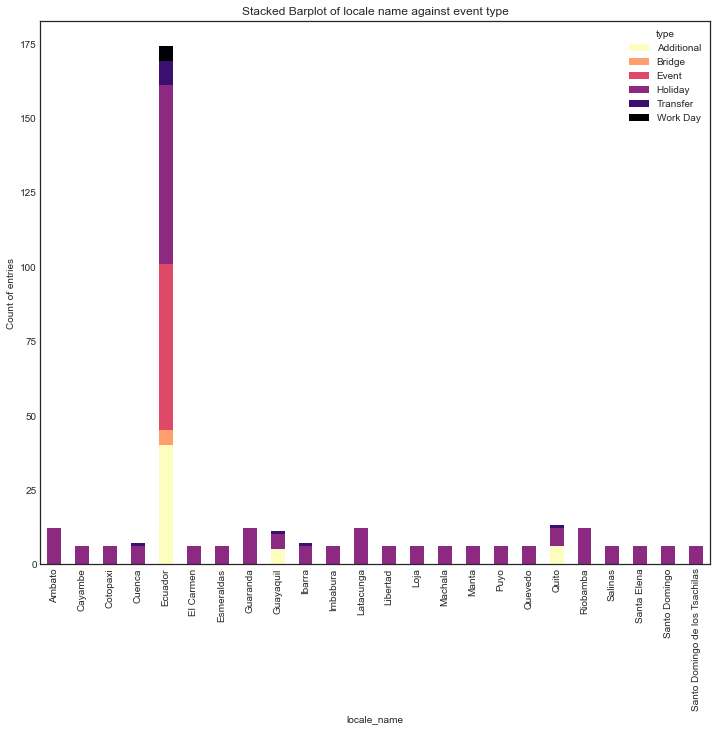

In [42]:
plt.style.use('seaborn-white')
# plt.style.use('dark_background')
holiday_local_type = holiday_events.groupby(['locale_name', 'type']).size()
holiday_local_type.unstack().plot(kind='bar',stacked=True, colormap= 'magma_r', figsize=(12,10),  grid=False)
plt.title('Stacked Barplot of locale name against event type')
plt.ylabel('Count of entries')
plt.show()

In [44]:
holiday_events.type.unique()

array(['Holiday', 'Transfer', 'Additional', 'Bridge', 'Work Day', 'Event'],
      dtype=object)

Transactions data

PERIODICITY IN TRANSACTION PATTERN

Inspecting the transactions file, we must be aware that the transactional data is only included for the training timeframe according to the competition's data dictionary. Furthermore the columns in this file relate only to the count of sales transactions for

In [45]:
print(transactions.head(3))
print("="*60)
print("There are {0} rows and {1} columns in the transactions data".
      format(transactions.shape[0], transactions.shape[1]))

        date  store_nbr  transactions
0 2013-01-01         25           770
1 2013-01-02          1          2111
2 2013-01-02          2          2358
There are 83488 rows and 3 columns in the transactions data


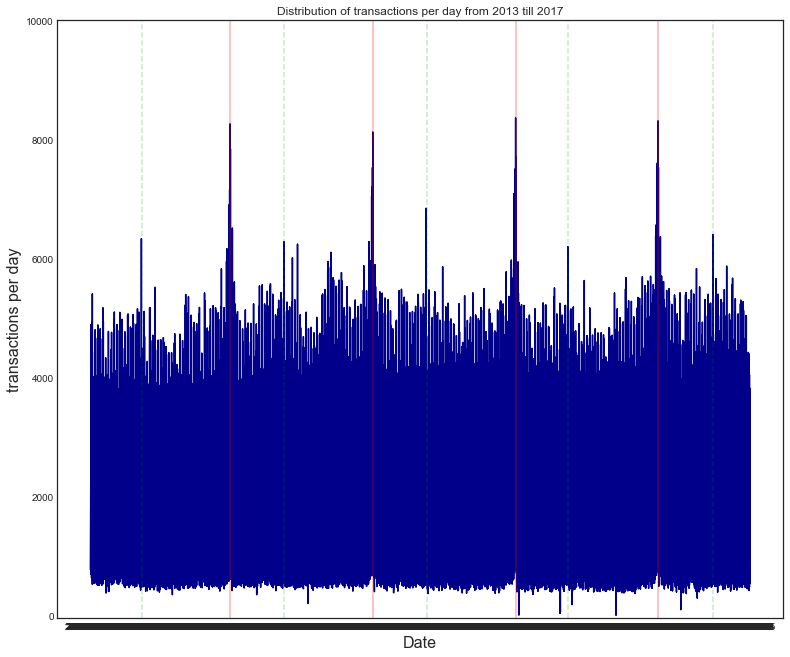

In [57]:
plt.style.use('seaborn-white')
plt.figure(figsize=(13,11))
plt.plot(transactions.date.values, transactions.transactions.values, color='darkblue')
plt.axvline(x='2015-12-23',color='red',alpha=0.3)
plt.axvline(x='2016-12-23',color='red',alpha=0.3)
plt.axvline(x='2014-12-23',color='red',alpha=0.3)
plt.axvline(x='2013-12-23',color='red',alpha=0.3)
plt.axvline(x='2013-05-12',color='green',alpha=0.2, linestyle= '--')
plt.axvline(x='2015-05-10',color='green',alpha=0.2, linestyle= '--')
plt.axvline(x='2016-05-08',color='green',alpha=0.2, linestyle= '--')
plt.axvline(x='2014-05-11',color='green',alpha=0.2, linestyle= '--')
plt.axvline(x='2017-05-14',color='green',alpha=0.2, linestyle= '--')
plt.ylim(-50, 10000)
plt.title("Distribution of transactions per day from 2013 till 2017")
plt.ylabel('transactions per day', fontsize= 16)
plt.xlabel('Date', fontsize= 16)
plt.show()

In [55]:
transactions.date.values

array(['2013-01-01', '2013-01-02', '2013-01-02', ..., '2017-08-15',
       '2017-08-15', '2017-08-15'], dtype=object)

In [56]:
transactions.transactions.values

array([ 770, 2111, 2358, ..., 2255,  932,  802], dtype=int64)

Takeaway from the plots

Interestingly when plotting transactions on a year-to-year basis, we can already pick out two different periodic spikes in transactions from the data (one in the solid Red line and the other the dotted Green line). The bigger yearly periodic spike in transactions seem to occur at the end of the year in December, specifically on the 23 December every year-end. Perhaps this is due to some sort of Christmas sale/discount that Corporacion Favorita holds every December thereby explaining the bump in transactions on this date. The weaker periodic spike given by the green dotted lines seems to occur around the middle of the months of May , specifically on the sunday in the second week of May. Perhaps another similar scheme is being implemented by Corporacion Favorita on those sundays.

Items data

Moving onto the "items.csv" file, we can see that there are not many columns in the data. There is a unique item number identifier "item_nbr" which I presume relates to mappings to grocery items such as "Housebrand tomatoes pack of 6" or maybe "4 blueberry muffins" etc. The family column should be pretty self-explanatory in the sense that this relates to parent category that that particular item relates to.

In [49]:
items.head()

,item_nbr,family,class,perishable
0,96995,GROCERY I,1093,0
1,99197,GROCERY I,1067,0
2,103501,CLEANING,3008,0
3,103520,GROCERY I,1028,0
4,103665,BREAD/BAKERY,2712,1


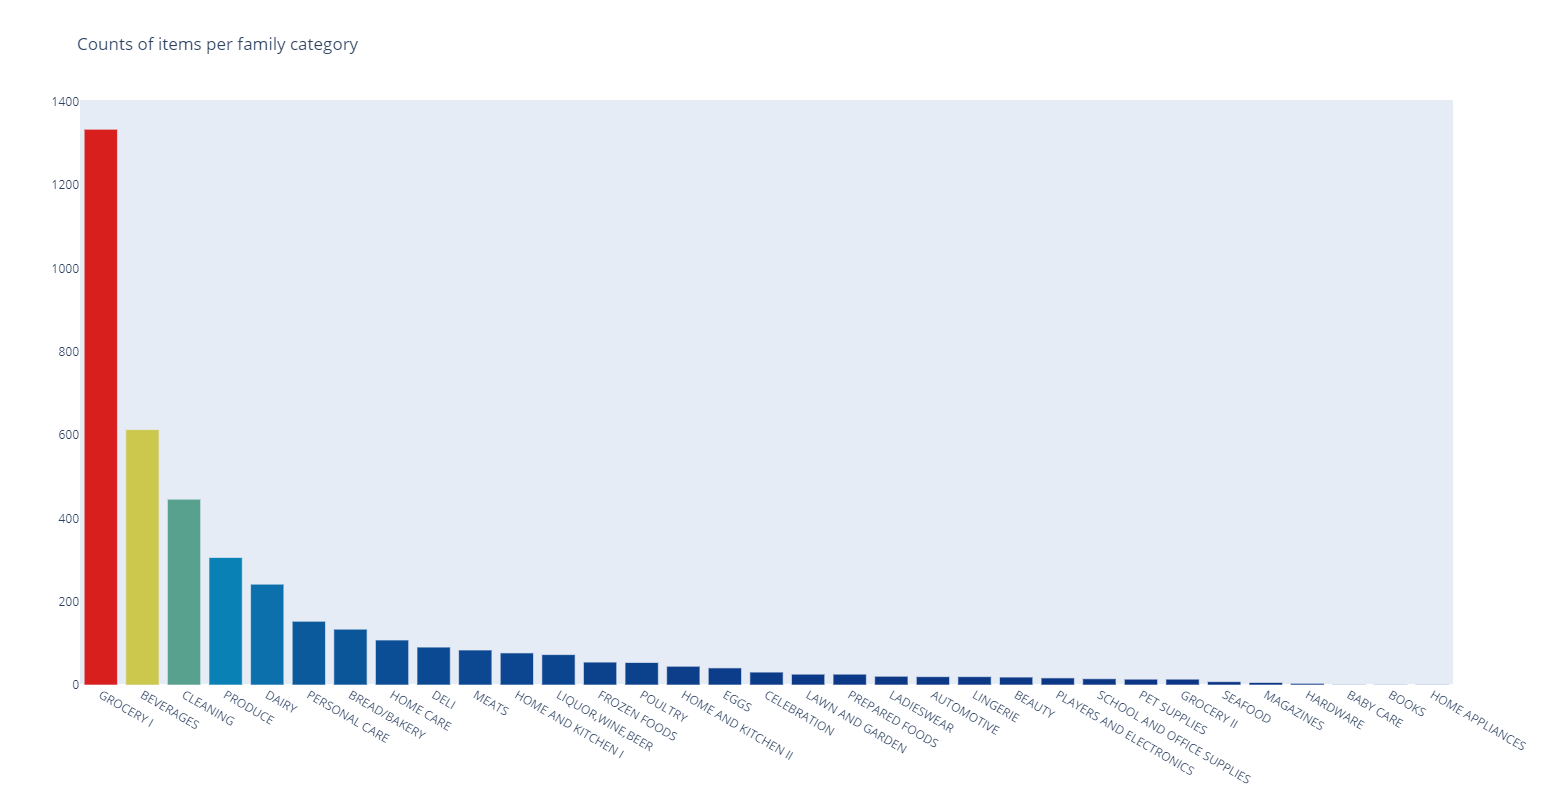

In [50]:
x, y = (list(x) for x in zip(*sorted(zip(items.family.value_counts().index, 
                                         items.family.value_counts().values), 
                                        reverse = False)))
trace2 = go.Bar(
    y=items.family.value_counts().values,
    x=items.family.value_counts().index,
    marker=dict(
        color=items.family.value_counts().values,
        colorscale = 'Portland',
        reversescale = False
    ),
    orientation='v',
)

layout = dict(
    title='Counts of items per family category',
     width = 800, height = 800,
    yaxis=dict(
        showgrid=False,
        showline=False,
        showticklabels=True,
#         domain=[0, 0.85],
    ))

fig1 = go.Figure(data=[trace2])
fig1['layout'].update(layout)
py.iplot(fig1, filename='plots')

Takeaways from the plot

As we can see from this barplot, the y-axis shows the counts of items while the x-axis displays the different family categories that the various retail items fall under, sorted from largest number of item counts to smallest number of items. As we can see from the plot, the top 3 family categories are the GROCERY I, BEVERAGES and CLEANING categories.

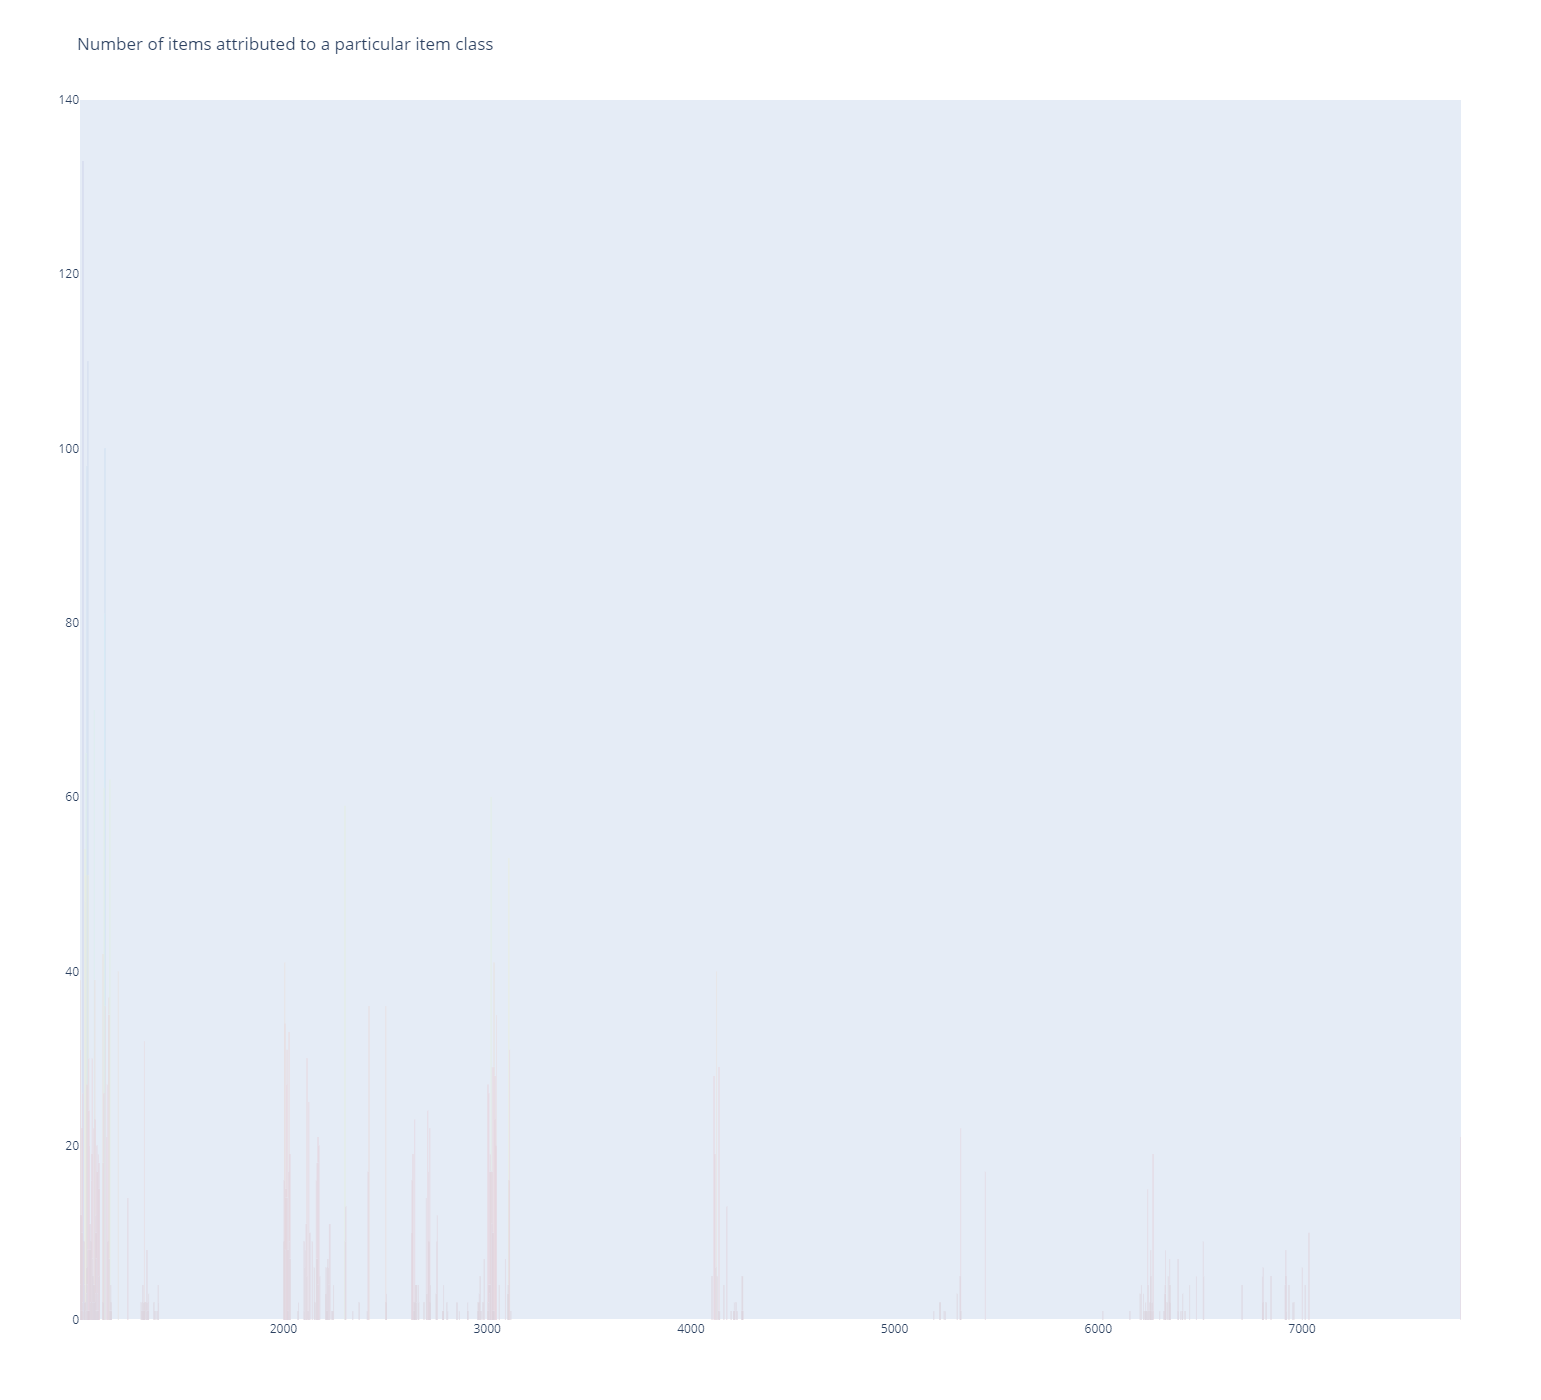

In [51]:
x, y = (list(x) for x in zip(*sorted(zip(items['class'].value_counts().index, 
                                         items['class'].value_counts().values), 
                                        reverse = False)))
trace2 = go.Bar(
    x=items['class'].value_counts().index,
    y=items['class'].value_counts().values,
    marker=dict(
        color=items['class'].value_counts().values,
        colorscale = 'Jet',
        reversescale = True
    ),
    orientation='v',
)

layout = dict(
    title='Number of items attributed to a particular item class',
     width = 800, height = 1400,
    yaxis=dict(
        showgrid=False,
        showline=False,
        showticklabels=True,
#         domain=[0, 0.85],
    ))

fig1 = go.Figure(data=[trace2])
fig1['layout'].update(layout)
py.iplot(fig1, filename='plots')

In [52]:
items.head()

,item_nbr,family,class,perishable
0,96995,GROCERY I,1093,0
1,99197,GROCERY I,1067,0
2,103501,CLEANING,3008,0
3,103520,GROCERY I,1028,0
4,103665,BREAD/BAKERY,2712,1


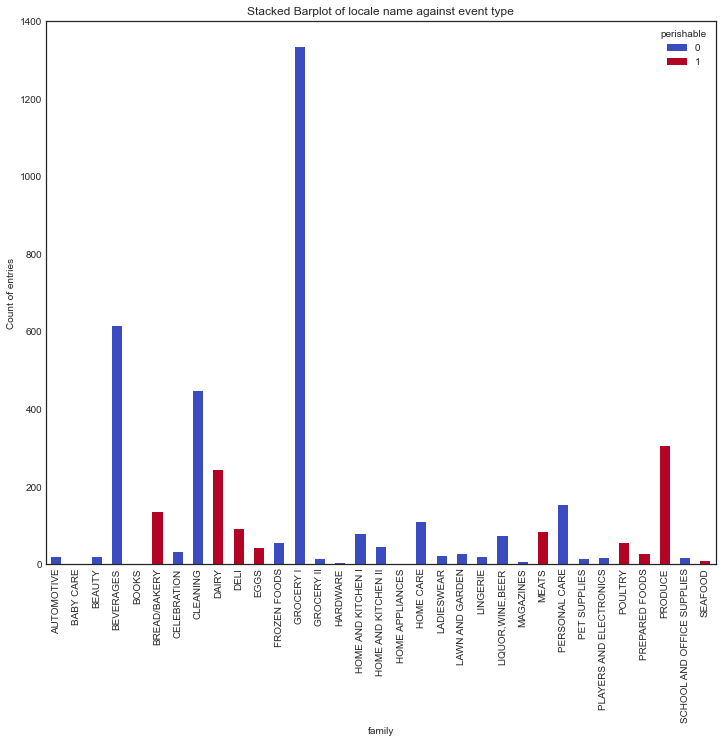

In [53]:
plt.style.use('seaborn-white')
fam_perishable = items.groupby(['family', 'perishable']).size()
fam_perishable.unstack().plot(kind='bar',stacked=True, colormap= 'coolwarm', figsize=(12,10),  grid=False)
plt.title('Stacked Barplot of locale name against event type')
plt.ylabel('Count of entries')
plt.show()

In [54]:
train.head()

,id,date,store_nbr,item_nbr,unit_sales,onpromotion
0,0,2013-01-01,25,103665,7.0,NaN
1,1,2013-01-01,25,105574,1.0,NaN
2,2,2013-01-01,25,105575,2.0,NaN
3,3,2013-01-01,25,108079,1.0,NaN
4,4,2013-01-01,25,108701,1.0,NaN


In [ ]:

id	date	store_nbr	item_nbr	unit_sales	onpromotion
0	0	2013-01-01	25	103665	7.0	NaN
1	1	2013-01-01	25	105574	1.0	NaN
2	2	2013-01-01	25	105575	2.0	NaN
3	3	2013-01-01	25	108079	1.0	NaN
4	4	2013-01-01	25	108701	1.0	NaN

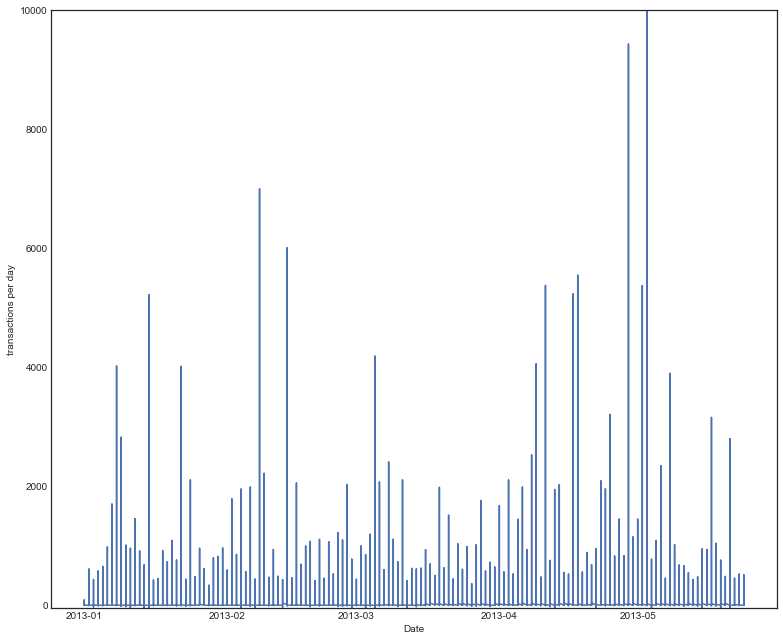

In [55]:
plt.style.use('seaborn-deep')
plt.figure(figsize=(13,11))
plt.plot(train.date.values, train.unit_sales)
plt.ylim(-50, 10000)
plt.ylabel('transactions per day')
plt.xlabel('Date')
plt.show()